In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from tensorflow.keras.utils import Sequence

In [3]:
folder_path = 'C:/Users/camer/Documents/Masters Thesis/Data/Training data/10secbatch_quotelogs'

training_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

Creating a scaler based on a subset of the data

In [3]:
# scaling_file = training_files[0:4]
# scaling_data = pd.read_csv(scaling_file)
# X_scaling = scaling_data.drop(columns=['quote_price', 'trader_type']).values
# scaler = StandardScaler()
# scaler.fit(X_scaling)

# joblib.dump(scaler, 'scaler_quote_1sec_v2.joblib')

scaler = StandardScaler()

for file in training_files:
    for chunk in pd.read_csv(file, chunksize=4096):
        X = chunk.drop(columns=['quote_price', 'trader_type']).values
        scaler.partial_fit(X)

scaler_filename = 'streaming_scaler_quote_log.joblib'
joblib.dump(scaler, scaler_filename)

['streaming_scaler_quote_log.joblib']

In [4]:
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

for file in training_files:
    for chunk in pd.read_csv(file, chunksize=32768):
        chunk = chunk[(chunk['quote_price'] >= 0) & (chunk['quote_price'] <= 500)]
        X = chunk.drop(columns=['quote_price', 'trader_type']).values
        y = chunk[['quote_price']].values
        input_scaler.partial_fit(X)
        output_scaler.partial_fit(y)

input_scaler_filename = 'input_scaler_quote_minmax_10secbatch.joblib'
output_scaler_filename = 'output_scaler_quote_minmax_10_secbatch.joblib'
joblib.dump(input_scaler, input_scaler_filename)
joblib.dump(output_scaler, output_scaler_filename)

['output_scaler_quote_minmax_10_secbatch.joblib']

In [5]:
# scaler = joblib.load('scalers/scaler_quote_log_minmax.joblib')

In [13]:
input_scaler = joblib.load('scalers/input_scaler_quote_minmax_10secbatch.joblib')
output_scaler = joblib.load('scalers/output_scaler_quote_minmax_10secbatch.joblib')

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, training_files, batch_size=1024, scaler=None, shuffle=False):
        self.training_files = training_files
        self.batch_size = batch_size
        self.scaler = scaler
        self.shuffle = shuffle
        self.current_file_idx = 0
        self.load_next_file()

    def load_next_file(self):
        if self.current_file_idx >= len(self.training_files):
            self.current_file_idx = 0
        self.current_file = self.training_files[self.current_file_idx]
        self.data_iterator = pd.read_csv(self.current_file, chunksize=self.batch_size)

    def __len__(self):
        total_rows = sum([pd.read_csv(file, usecols=[0]).shape[0] for file in self.training_files])
        return total_rows // self.batch_size

    def __getitem__(self, index):
        try:
            chunk = next(self.data_iterator)
        except StopIteration:
            self.current_file_idx += 1
            self.load_next_file()
            chunk = next(self.data_iterator)
        chunk = chunk[chunk['quote_price'] <= 500]
        chunk = chunk[chunk['quote_price'] >= 0]
        X_batch = chunk.drop(columns=['quote_price', 'trader_type']).values
        y_batch = chunk['quote_price'].values

        if self.scaler:
            X_batch = self.scaler.transform(X_batch)

        X_batch = X_batch.reshape((-1, 1, X_batch.shape[1]))

        return X_batch.astype(np.float16), y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.training_files)
        self.current_file_idx = 0
        self.load_next_file()

In [5]:
class DataGenerator(Sequence):
    def __init__(self, training_files, batch_size=1024, input_scaler=None, output_scaler=None, shuffle=False):
        self.training_files = training_files
        self.batch_size = batch_size
        self.input_scaler = input_scaler
        self.output_scaler = output_scaler
        self.shuffle = shuffle
        self.current_file_idx = 0
        self.load_next_file()
        
    def load_next_file(self):
        if self.current_file_idx >= len(self.training_files):
            self.current_file_idx = 0
        self.current_file = self.training_files[self.current_file_idx]
        self.data_iterator = pd.read_csv(self.current_file, chunksize=self.batch_size)

    def __len__(self):
        total_rows = sum([pd.read_csv(file, usecols=[0]).shape[0] for file in self.training_files])
        return total_rows // self.batch_size

    def __getitem__(self, index):
        try:
            chunk = next(self.data_iterator)
        except StopIteration:
            self.current_file_idx += 1
            self.load_next_file()
            chunk = next(self.data_iterator)
        chunk = chunk[(chunk['quote_price'] >= 0) & (chunk['quote_price'] <= 500)]
        X_batch = chunk.drop(columns=['quote_price', 'trader_type']).values
        y_batch = chunk['quote_price'].values

        if self.input_scaler:
            X_batch = self.input_scaler.transform(X_batch)
        if self.output_scaler:
            y_batch = self.output_scaler.transform(y_batch.reshape(-1, 1)).flatten()

        X_batch = X_batch.reshape((-1, 1, X_batch.shape[1]))

        return X_batch.astype(np.float16), y_batch.astype(np.float16)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.training_files)
        self.current_file_idx = 0
        self.load_next_file()

In [6]:
train_files, test_files = train_test_split(training_files, test_size=0.1, random_state=42)

train_generator = DataGenerator(train_files, batch_size=16384, input_scaler=input_scaler, output_scaler=output_scaler, shuffle=False)
test_generator = DataGenerator(test_files, batch_size=16384, input_scaler=input_scaler, output_scaler=output_scaler, shuffle=False)

# test_data_list = []

# for test_file in test_files:
#     test_data_sample = pd.read_csv(test_file)
#     test_data_list.append(test_data_sample)
 
# test_data = pd.concat(test_data_list, ignore_index=True)

# X_test = test_data.drop(columns=['quote_price', 'trader_type']).values
# y_test = test_data['quote_price'].values

# X_test_scaled = scaler.transform(X_test)

# X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [7]:
model = Sequential()
model.add(InputLayer(shape=(1, train_generator[0][0].shape[2]), dtype=tf.float16))
model.add(LSTM(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000015)
model.compile(optimizer='adam', loss='mean_squared_error')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Neural_network_models/quote_log_model/epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_best_only=False,
    verbose=1
)

history = model.fit(train_generator, epochs=30, validation_data=test_generator, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/30


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16293/16300 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0063

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: saving model to Neural_network_models/quote_log_model/epoch_01.keras
16300/16300 ━━━━━━━━━━━━━━━━━━━━ 773s 35ms/step - loss: 0.0063 - val_loss: 0.0039
Epoch 2/30
16292/16300 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0040
Epoch 2: saving model to Neural_network_models/quote_log_model/epoch_02.keras
16300/16300 ━━━━━━━━━━━━━━━━━━━━ 741s 33ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 3/30
16293/16300 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040
Epoch 3: saving model to Neural_network_models/quote_log_model/epoch_03.keras
16300/16300 ━━━━━━━━━━━━━━━━━━━━ 747s 33ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 4/30
16293/16300 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0039
Epoch 4: saving model to Neural_network_models/quote_log_model/epoch_04.keras
16300/16300 ━━━━━━━━━━━━━━━━━━━━ 750s 33ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 5/30
16294/16300 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0038
Epoch 5: saving model to Neural_network_models/quote_log_model/epoch_05

16300/16300 ━━━━━━━━━━━━━━━━━━━━ 820s 37ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 29/30
16293/16300 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0037
Epoch 29: saving model to Neural_network_models/quote_log_model/epoch_29.keras
16300/16300 ━━━━━━━━━━━━━━━━━━━━ 816s 37ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 30/30
16293/16300 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0037
Epoch 30: saving model to Neural_network_models/quote_log_model/epoch_30.keras
16300/16300 ━━━━━━━━━━━━━━━━━━━━ 814s 37ms/step - loss: 0.0037 - val_loss: 0.0036


In [8]:
joblib.dump(history.history, 'training_history_quote_log_v1_10secbatch.pkl')

['training_history_quote_log_v1_10secbatch.pkl']

In [9]:
model.save('Neural_network_models/quote_log_model_1sec_v1_10secbatch.keras')

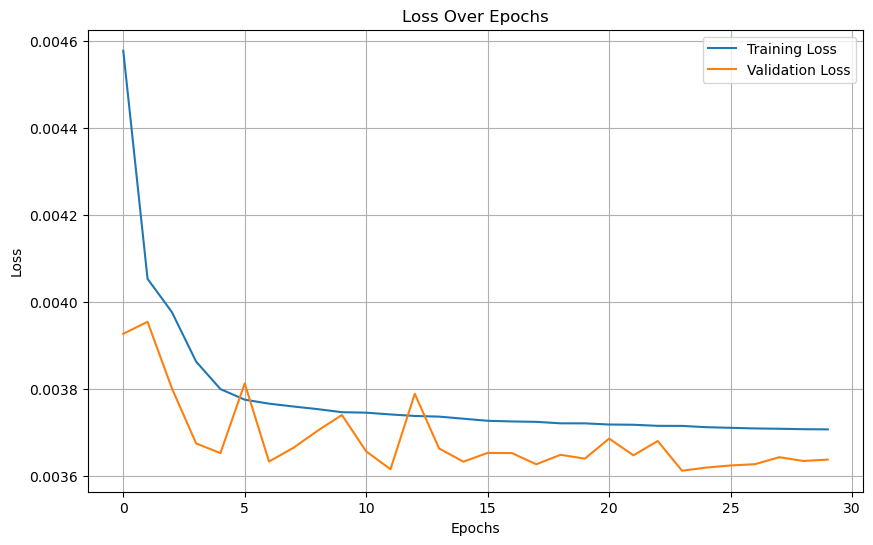

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from tensorflow.keras.models import load_model

model = load_model('C:/Users/camer/Documents/Masters Thesis/Deep-Learning-Trader-BFBSE/Neural_network_models/quote_log_model_1sec_v5.keras')


In [17]:
tf.saved_model.save(model, 'C:/Users/camer/Documents/Masters Thesis/Deep-Learning-Trader-BFBSE/Neural_network_models/quote_log_model_1sec_v5_AWS.pd')

INFO:tensorflow:Assets written to: C:/Users/camer/Documents/Masters Thesis/Deep-Learning-Trader-BFBSE/Neural_network_models/quote_log_model_1sec_v5_AWS.pd\assets


INFO:tensorflow:Assets written to: C:/Users/camer/Documents/Masters Thesis/Deep-Learning-Trader-BFBSE/Neural_network_models/quote_log_model_1sec_v5_AWS.pd\assets


## Old code below

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, training_files, batch_size=1024, scaler=None, shuffle=False):
        self.training_files = training_files
        self.batch_size = batch_size
        self.scaler = scaler
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.training_files))
        self.current_file = None
        self.data_iterator = None
        self.on_epoch_end()

    def __len__(self):
        total_rows = sum([pd.read_csv(file, usecols=[0]).shape[0] for file in self.training_files])
        return int(np.ceil(total_rows / self.batch_size))

    def __getitem__(self, index):
        if self.data_iterator is None or self.current_file is None or not self.has_next_chunk():
            self.current_file = self.training_files[self.indexes[index]]
            self.data_iterator = pd.read_csv(self.current_file, chunksize=self.batch_size)

        chunk = next(self.data_iterator)
        X_batch = chunk.drop(columns=['quote_price', 'trader_type']).values
        y_batch = chunk['quote_price'].values

        if self.scaler:
            X_batch = self.scaler.transform(X_batch)

        X_batch = X_batch.reshape((-1, 1, X_batch.shape[1]))

        return X_batch.astype(np.float16), y_batch
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.training_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        self.current_file = None
        self.data_iterator = None

    def has_next_chunk(self):
        try:
            _ = next(self.data_iterator)
            self.data_iterator = pd.read_csv(self.current_file, chunksize=self.batch_size)
            return True
        except StopIteration:
            return False


In [ ]:
test_loss = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test Loss: {test_loss}')

In [35]:
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)

923519/923519 ━━━━━━━━━━━━━━━━━━━━ 783s 848us/step


NameError: name 'mean_absolute_error' is not defined

In [42]:
print(f"Predicted: {y_pred[10000000]}, Actual: {y_test[10000000]}")

Predicted: [127.69873], Actual: 98
